<a href="https://colab.research.google.com/github/PravinVedurla/Cat-and-Dogs-Cassification-using-Resnet-Pytorch-/blob/master/Cats_and_Dogs_with_Resnet_%5BPytorch%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-06-17 18:45:59--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 2404:6800:4003:80a::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  55.3MB/s    in 1.2s    

2019-06-17 18:46:00 (55.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [3]:
os.chdir('/tmp')
print(os.listdir())

['cats_and_dogs_filtered.zip']


In [4]:
!unzip '/tmp/cats_and_dogs_filtered.zip'

Archive:  /tmp/cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.

In [5]:
for dirpath, dirnames,_ in os.walk('/tmp/cats_and_dogs_filtered'):
  print('Current Path:', dirpath)
  print('Directories:', dirnames)

Current Path: /tmp/cats_and_dogs_filtered
Directories: ['train', 'validation']
Current Path: /tmp/cats_and_dogs_filtered/train
Directories: ['cats', 'dogs']
Current Path: /tmp/cats_and_dogs_filtered/train/cats
Directories: []
Current Path: /tmp/cats_and_dogs_filtered/train/dogs
Directories: []
Current Path: /tmp/cats_and_dogs_filtered/validation
Directories: ['cats', 'dogs']
Current Path: /tmp/cats_and_dogs_filtered/validation/cats
Directories: []
Current Path: /tmp/cats_and_dogs_filtered/validation/dogs
Directories: []


In [0]:
# Base Directory defined.
base_dir = '/tmp/cats_and_dogs_filtered'

# Train and Validation directory Defined.
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [7]:
fnames_cats = os.listdir(train_cats_dir)
print(f'File names of Cats:', fnames_cats[:10])

fnames_dogs = os.listdir(train_dogs_dir)
print(f"File names of Dogs:", fnames_dogs[:10])

File names of Cats: ['cat.239.jpg', 'cat.680.jpg', 'cat.279.jpg', 'cat.847.jpg', 'cat.170.jpg', 'cat.937.jpg', 'cat.692.jpg', 'cat.831.jpg', 'cat.850.jpg', 'cat.54.jpg']
File names of Dogs: ['dog.514.jpg', 'dog.192.jpg', 'dog.504.jpg', 'dog.607.jpg', 'dog.152.jpg', 'dog.860.jpg', 'dog.454.jpg', 'dog.522.jpg', 'dog.32.jpg', 'dog.784.jpg']


In [8]:
print('Number of training examples of Cats:', len(os.listdir(train_cats_dir)))
print('Number of training examples of Dogs:', len(os.listdir(train_dogs_dir)))
print('Number of testing examples of cats:', len(os.listdir(validation_cats_dir)))
print('Number of testing examples of Dogs:', len(os.listdir(validation_dogs_dir)))

Number of training examples of Cats: 1000
Number of training examples of Dogs: 1000
Number of testing examples of cats: 500
Number of testing examples of Dogs: 500


In [0]:
# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomGrayscale(),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])


test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(validation_dir, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

In [0]:
# Device shifts to GPU is it's available or stays with CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# Defining Model as Resnet50 pretrained and extracted from Models of torchvision
model = models.resnet50(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:06<00:00, 17019897.79it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
# Time to Freeze params of the downloaded model.
for params in model.parameters():
  params.requires_grad = False

classifier = nn.Sequential(nn.Linear(2048, 512),
                           nn.ReLU(),
                           nn.Dropout(p=0.2),
                           nn.Linear(512, 2),
                           nn.LogSoftmax(dim=1))

model.fc = classifier

In [13]:
# Defining Loss criterion and Optimiser
criterion = nn.NLLLoss()
optimiser = optim.Adam(model.fc.parameters(), lr=0.003)

# Moves the model to either CPU or GPU
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
#!pip install helper==2.4.2
#images, labels = next(iter(trainloader))
#helper.imshow(images[0], normalize=False)

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

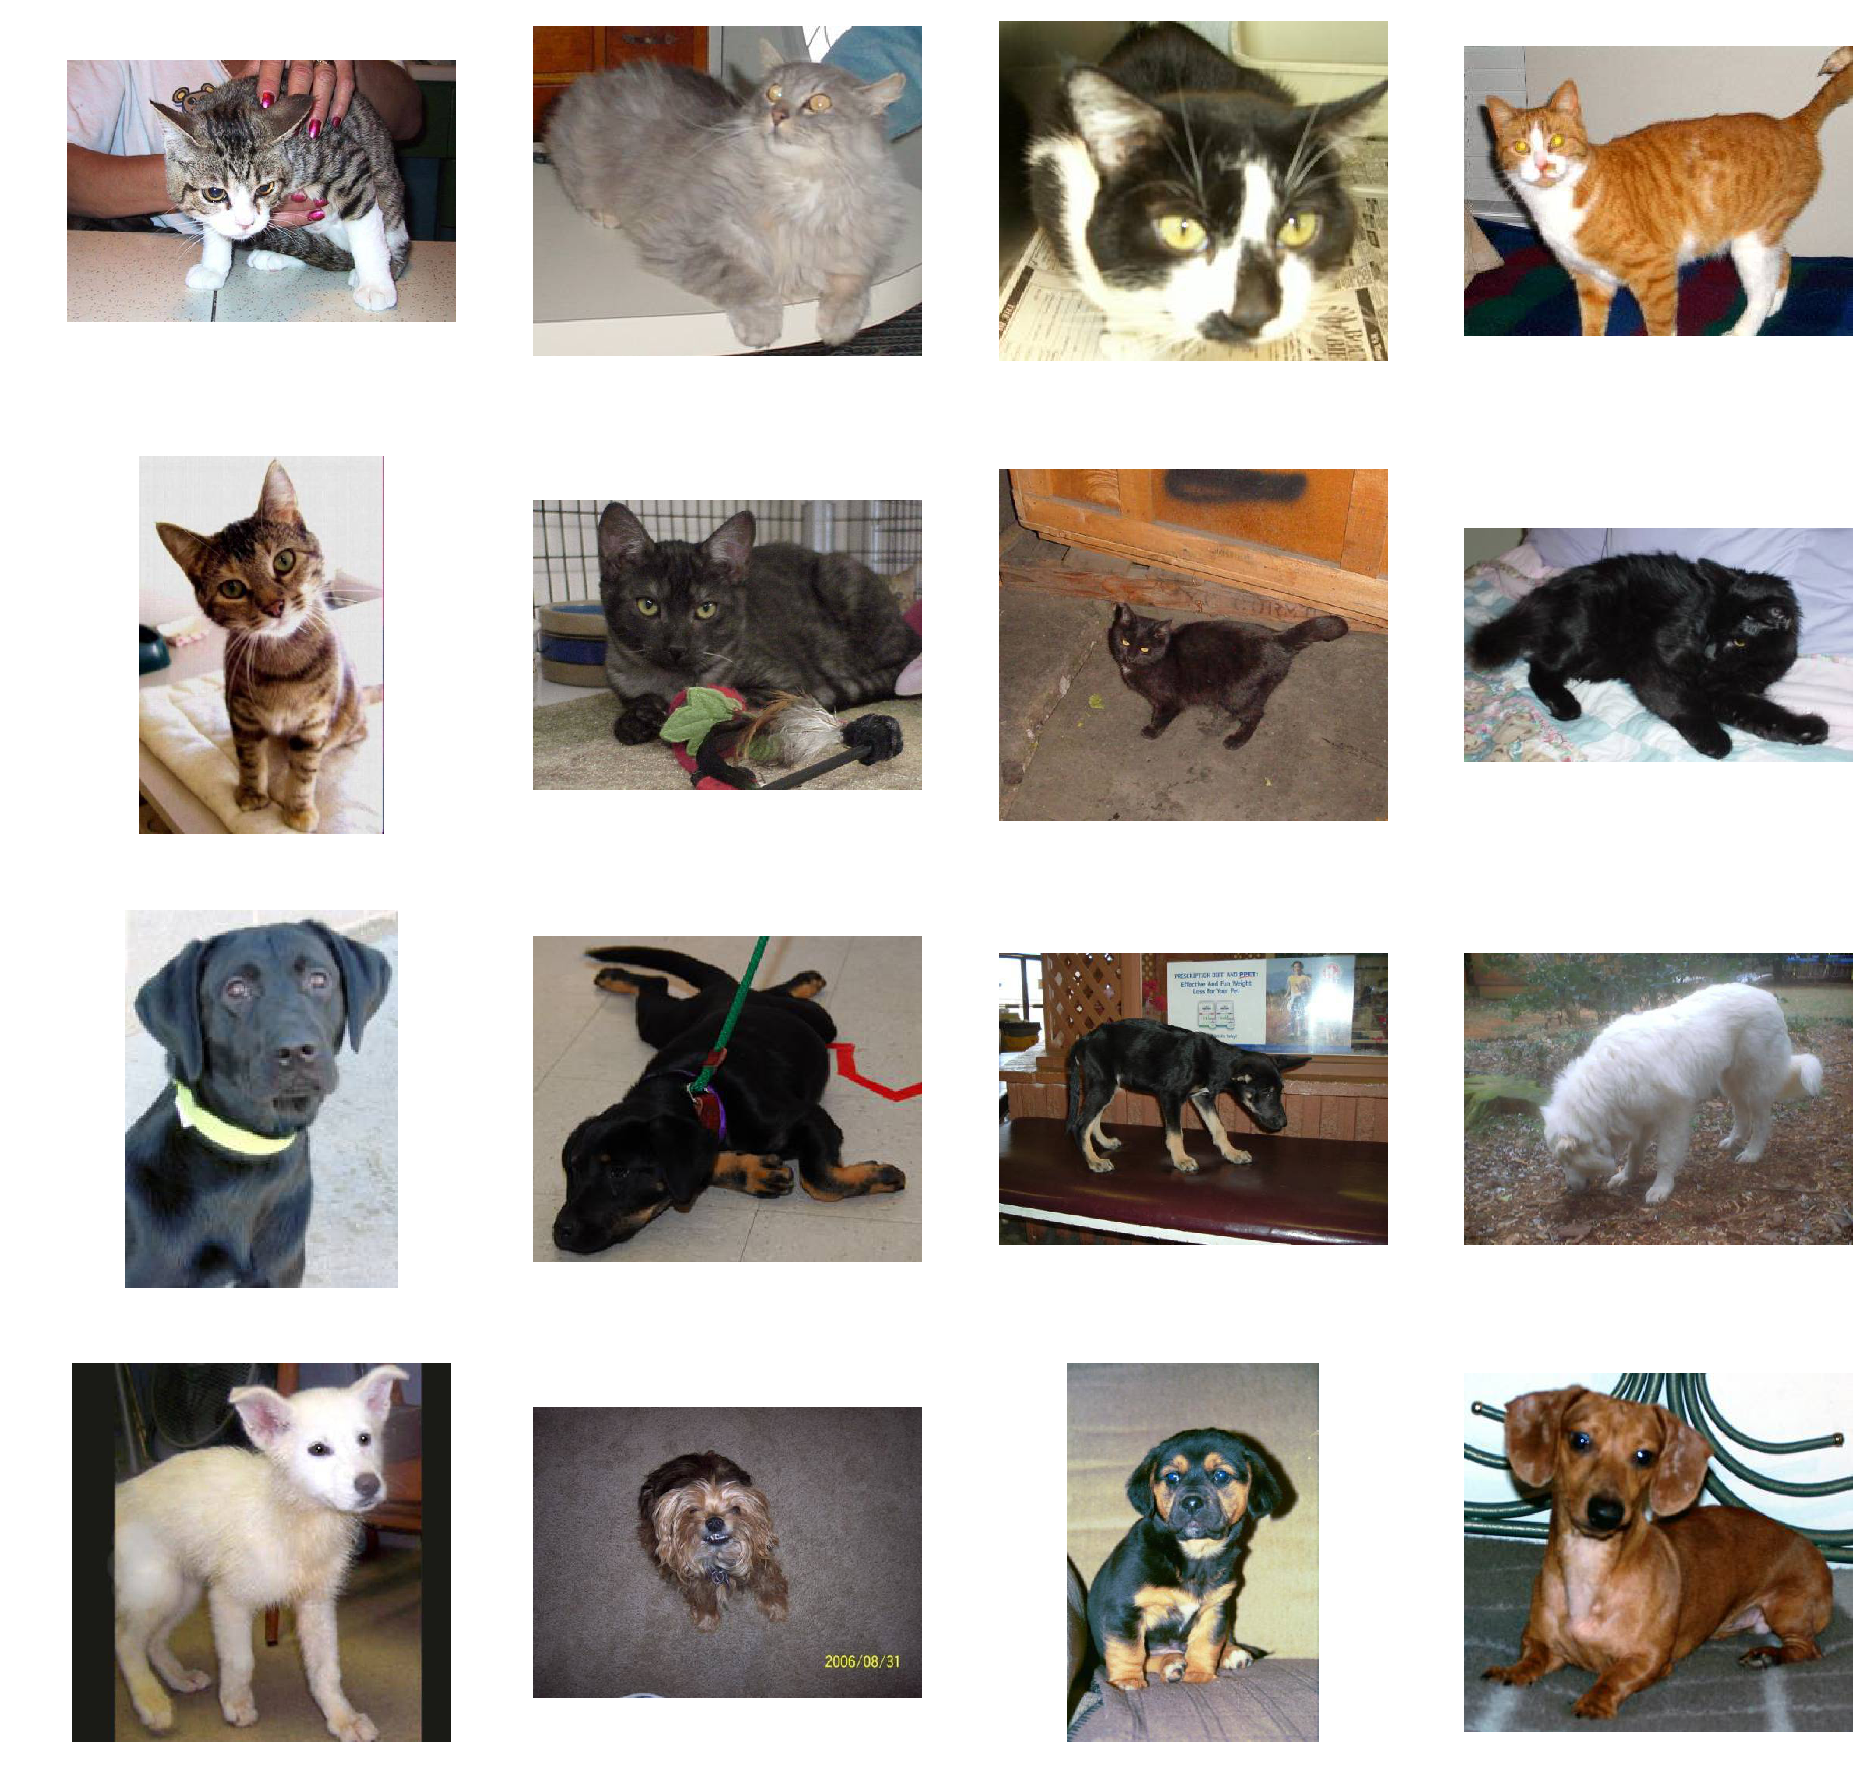

In [16]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in fnames_cats[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in fnames_dogs[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [17]:
traininglosses =[]
testinglosses= []
testaccuracy= []
totalsteps= []

epochs = 1
steps = 0
runn = 0
print_every = 5

for epoch in range(epochs):
    for images, labels in trainloader:
        steps += 1
        
        images, labels = images.to(device), labels.to(device)
        
        optimiser.zero_grad()
        
        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        
        optimiser.step()
        
        runn += loss.item()
        
        if steps % print_every == 0:
            model.eval()
            test_loss = 0
            acc = 0
            
            for images, labels in testloader:
                
                images, labels= images.to(device), labels.to(device)
                
                logps = model(images)
                loss = criterion(logps, labels)
                test_loss += loss.item()
                
                ps = torch.exp(logps)
                top_ps, top_c = ps.topk(1, dim=1)
                equal = top_c == labels.view(top_c.shape)
                acc += torch.mean(equal.type(torch.FloatTensor)).item()
                
            traininglosses.append(runn/print_every)
            testinglosses.append(test_loss/len(testloader))
            testaccuracy.append(acc/len(testloader))
            totalsteps.append(steps)    
                
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {runn/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {acc/len(testloader):.3f}")
            runn = 0
            model.train()

Epoch 1/1.. Train loss: 2.978.. Test loss: 0.721.. Test accuracy: 0.515
Epoch 1/1.. Train loss: 0.851.. Test loss: 0.185.. Test accuracy: 0.980
Epoch 1/1.. Train loss: 0.559.. Test loss: 0.198.. Test accuracy: 0.939
Epoch 1/1.. Train loss: 0.354.. Test loss: 0.185.. Test accuracy: 0.941
Epoch 1/1.. Train loss: 0.295.. Test loss: 0.171.. Test accuracy: 0.937
Epoch 1/1.. Train loss: 0.352.. Test loss: 0.141.. Test accuracy: 0.960
Epoch 1/1.. Train loss: 0.336.. Test loss: 0.095.. Test accuracy: 0.974
Epoch 1/1.. Train loss: 0.318.. Test loss: 0.097.. Test accuracy: 0.970
Epoch 1/1.. Train loss: 0.268.. Test loss: 0.125.. Test accuracy: 0.959
Epoch 1/1.. Train loss: 0.324.. Test loss: 0.073.. Test accuracy: 0.980
Epoch 1/1.. Train loss: 0.169.. Test loss: 0.157.. Test accuracy: 0.937
Epoch 1/1.. Train loss: 0.319.. Test loss: 0.083.. Test accuracy: 0.973


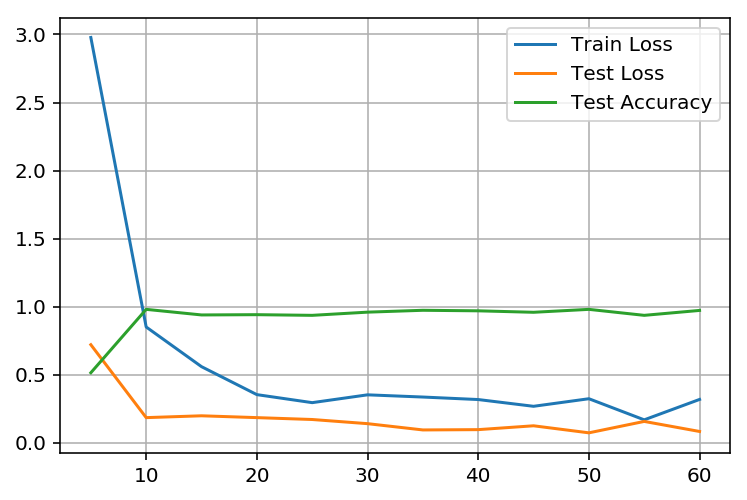

In [18]:
plt.plot(totalsteps, traininglosses, label='Train Loss')
plt.plot(totalsteps, testinglosses, label='Test Loss')
plt.plot(totalsteps, testaccuracy, label='Test Accuracy')
plt.legend()
plt.grid()
plt.show()

Saving the model after its trained!

In [0]:
checkpoint = {
    'parameters' : model.parameters,
    'state_dict' : model.state_dict()
}

In [0]:

torch.save(checkpoint, './catvdog.pth')